In [9]:
from ralph_tools import *
import re
import os
from matplotlib_scalebar.scalebar import ScaleBar
import time
import numpy as np
from glob import glob
from igor2 import binarywave
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [10]:
def jet_with_zero_transparent(n_colors=256):
    """
    Create a 'jet' colormap where only the lowest value (0) is fully transparent,
    and all other values are fully opaque.
    """
    base = plt.get_cmap('jet', n_colors)
    colors = base(np.arange(n_colors))
    
    # Make first color (lowest value) transparent, rest fully opaque
    colors[:, -1] = 1.0
    colors[:20, -1] = 0.0
    
    return ListedColormap(colors)


def unitize(ux, uy, uz, eps=1e-12):
    ux = np.asanyarray(ux, dtype=float)
    uy = np.asanyarray(uy, dtype=float)
    uz = np.asanyarray(uz, dtype=float)
    U = np.stack((ux, uy, uz), axis=-1)  # (H,W,3)
    mag = np.linalg.norm(U, axis=-1)
    valid = mag > eps
    mag_safe = mag.copy()
    mag_safe[~valid] = 1.0
    U_dir = U / mag_safe[..., None]
    U_dir[~valid] = 0.0
    return U_dir, valid

def angle_between_unit(a, b):
    # a,b shape (...,3)
    dot = np.sum(a * b, axis=-1)
    dot = np.clip(dot, -1.0, 1.0)
    return np.arccos(dot)

def most_common_opposite_angle_map_discrete(
        ux, uy, uz,
        radius=3,
        bin_width=np.pi/36,   # default: 5 degree bins
        min_pairs_required=4,
        eps=1e-12
    ):
    """
    For each pixel compute the most common angle (radians) between opposite discrete pixel pairs
    within integer offsets in a radius.

    Parameters
    ----------
    ux, uy, uz : 2D arrays (complex or real)
        Vector field components.
    radius : int
        Max integer radius to consider. Offsets considered are all integer (dy,dx) with
        dy^2 + dx^2 <= radius^2 and not (0,0).
    bin_width : float
        Histogram bin width in radians (must evenly divide pi for convenience but not required).
    min_pairs_required : int
        Minimum valid opposite pairs required to return a mode; otherwise result is np.nan.
    eps : float
        Small value to avoid division by zero when normalizing.

    Returns
    -------
    mode_map : float array (H,W)
        Per-pixel most common angle (radians) — center of modal bin; np.nan where insufficient pairs.
    modal_count_map : int array (H,W)
        Count of samples inside the modal bin for each pixel.
    total_pairs_map : int array (H,W)
        Total number of valid opposite pairs used for each pixel.
    bin_centers : 1D array
        The centers of histogram bins used (useful for interpretation).
    """
    # 1) Use real parts
    ux_r = np.real(ux)
    uy_r = np.real(uy)
    uz_r = np.real(uz)

    H, W = ux_r.shape

    # 2) Precompute unit vectors and valid mask
    U_dir, valid_vec_mask = unitize(ux_r, uy_r, uz_r, eps=eps)  # shape (H,W,3)

    # 3) Prepare integer offset list (dy,dx) within radius (exclude 0,0).
    offsets = []
    r2 = radius * radius
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dy == 0 and dx == 0:
                continue
            if dy*dy + dx*dx <= r2:
                # ensure we only keep one of the opposite pairs set later; we'll use both p+(dy,dx) & p-(dy,dx)
                # Keep every offset; opposite is just negative offset.
                offsets.append((dy, dx))
    # offsets contains duplicates of opposites; that's fine because each offset will generate one opposite pair.

    # 4) Histogram bin edges and centers (0..pi)
    # Ensure last edge >= pi
    n_bins = int(np.ceil(np.pi / bin_width))
    bin_edges = np.linspace(0.0, n_bins * bin_width, n_bins + 1)
    # if bin_edges[-1] < pi: extend one more bin to include pi
    if bin_edges[-1] < np.pi:
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        n_bins = len(bin_edges) - 1
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Prepare outputs
    mode_map = np.full((H, W), np.nan, dtype=float)
    modal_count_map = np.zeros((H, W), dtype=int)
    total_pairs_map = np.zeros((H, W), dtype=int)

    # 5) Iterate over pixels (can be slow for very large images)
    for iy in range(H):
        for ix in range(W):
            angles_collected = []

            # For each integer offset, check both endpoints are in-bounds and valid vectors
            for (dy, dx) in offsets:
                y_plus = iy + dy
                x_plus = ix + dx
                y_minus = iy - dy
                x_minus = ix - dx

                # check bounds
                if (y_plus < 0 or y_plus >= H or x_plus < 0 or x_plus >= W or
                    y_minus < 0 or y_minus >= H or x_minus < 0 or x_minus >= W):
                    continue

                # check vector validity at both points
                if (not valid_vec_mask[y_plus, x_plus]) or (not valid_vec_mask[y_minus, x_minus]):
                    continue

                v_plus = U_dir[y_plus, x_plus, :]
                v_minus = U_dir[y_minus, x_minus, :]

                # compute angle
                ang = angle_between_unit(v_plus[None, :], v_minus[None, :])[0]
                # store
                angles_collected.append(ang)

            # end offsets loop

            total_pairs = len(angles_collected)
            total_pairs_map[iy, ix] = total_pairs

            if total_pairs >= min_pairs_required:
                counts, _ = np.histogram(angles_collected, bins=bin_edges)
                max_idx = np.argmax(counts)
                modal_count = counts[max_idx]
                modal_angle = bin_centers[max_idx]
                mode_map[iy, ix] = modal_angle
                modal_count_map[iy, ix] = int(modal_count)
            else:
                mode_map[iy, ix] = np.nan
                modal_count_map[iy, ix] = 0

    return mode_map, modal_count_map, total_pairs_map, bin_centers


In [14]:
file_loc = r'D:\User Data\Ralph\3DPFM_Test\PolyPZT'
base_filename = 'Image'
log_filename = 'Log_3DPFM'

In [15]:

os.chdir(file_loc)
with (h5py.File(base_filename+'.hf5', 'r')) as f:
    ux = f['3DPFM/ux'][:]
    uy = f['3DPFM/uy'][:]
    uz = f['3DPFM/uz'][:]
    
    priority = ['B', 'C', 'A', 'E']
    Cnt = next((x for x in priority if x in f.keys()), None)
    
    topo = f[Cnt+'/Channel_000/Channel_000/Channel_000'][:]
    scale = f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['FastScanSize']/f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['PointsLines']


In [16]:
mode_map, modal_count, total_pairs, bin_centers = most_common_opposite_angle_map_discrete(
    ux, uy, uz,
    radius=7,
    bin_width=np.pi/20,
    min_pairs_required=6
)


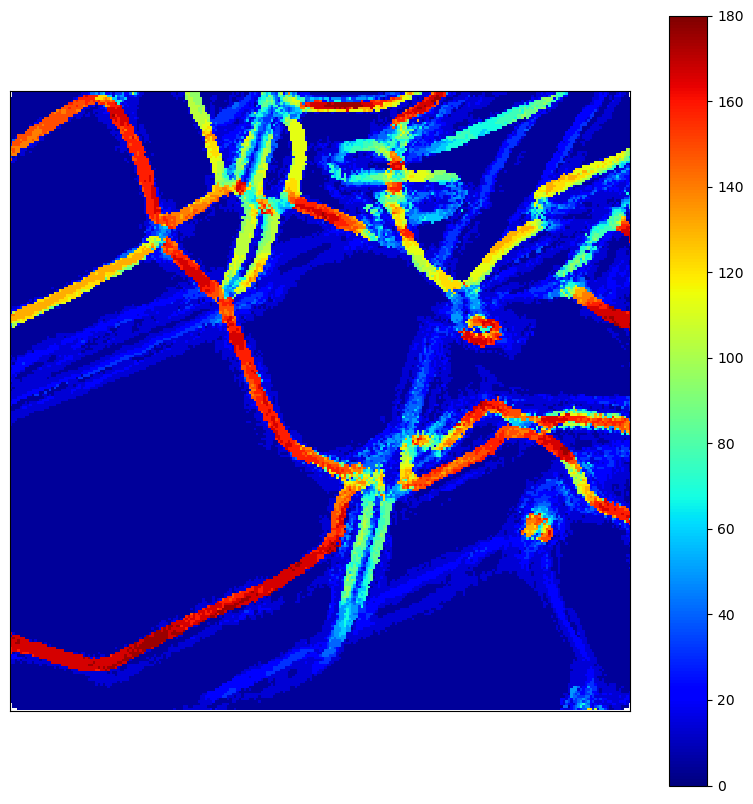

In [17]:
plt.figure(figsize=(10,10))

plt.imshow(mode_map*180/np.pi, vmin = 0, vmax = 180, cmap = 'jet', interpolation = 'none')
plt.xticks([])
plt.yticks([])
plt.colorbar()

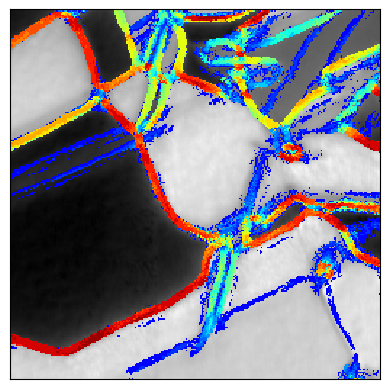

In [18]:

U_mag = np.sqrt(np.abs(ux)**2+np.abs(uy)**2+np.abs(uz)**2)
background_img = np.real(uz).copy()

angle_deg = mode_map * 180 / np.pi

jet_zero_transparent = jet_with_zero_transparent()

plt.imshow(background_img, cmap='binary_r', interpolation='none')

plt.imshow(angle_deg, vmin=0, vmax=180,
           cmap=jet_zero_transparent, interpolation='none')

plt.xticks([])
plt.yticks([])
#plt.colorbar(label="Angle (°)")
plt.show()


(0.0, 180.0)

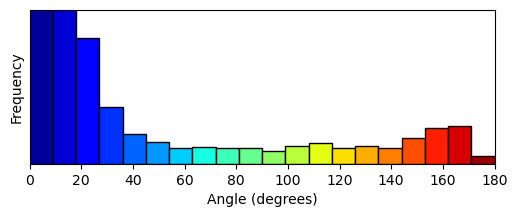

In [19]:



angle_deg_flatten = angle_deg.flatten()
angle_deg_flatten = angle_deg_flatten[~np.isnan(angle_deg_flatten)]


plt.figure(figsize=(6, 2))

# Histogram with fixed bins 0..180 (20 bins -> 9° each)
hist, bins = np.histogram(angle_deg_flatten, bins=20, range=(0, 180))

# Drop the first two bins
hist = hist[:]                # len = 18
left = bins[:-1]              # edges i=2..19 -> len = 18 (left edges)
right = bins[1:]               # edges i=3..20 -> len = 18 (right edges)
width = right - left           # len = 18
centers = 0.5 * (left + right) # len = 18

# Colors from jet mapped to 0..180
norm = mcolors.Normalize(vmin=0, vmax=180)
colors = cm.jet(norm(centers))

# Plot
plt.bar(left, hist, width=width, align='edge', edgecolor='black', color=colors)

# Optional colorbar
# sm = cm.ScalarMappable(cmap=cm.jet, norm=norm); sm.set_array([])
# plt.colorbar(sm, label='Angle (degrees)')

plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.yticks([])
plt.ylim([0, 5000])
plt.xlim([0,180])

#plt.savefig('AngleHist.png', dpi=180, bbox_inches='tight')
#plt.savefig('AngleHist.eps', bbox_inches='tight')
#plt.close()
